# 第十三次课后练习 （选做）

**负责助教：朱轩宇**

<span style="color:red; font-weight:bold;">请将作业文件命名为 第十三次课后练习-选做题+姓名+学号.ipynb, 例如 第十三次课后练习-选做题+张三+1000000000.ipynb</span>

# 红楼梦人物关系网络分析

## 引言
《红楼梦》作为中国古典文学巅峰之作，其复杂的人物关系网络蕴含着深刻的社会学价值。在实验中，我们运用复杂网络分析方法，构建包含**宁荣两府核心人物及关联家族**的多层网络，揭示隐藏的社会结构和权力分布。


## 实验步骤
1. 数据预处理
   - 使用pandas读取数据文件，并进行数据清洗和预处理，包括去除重复值、关系权重映射等。
2. 多层网络构建
   1. 使用MultiDiGraph同时记录核心人物关系和家族间关系
3. 社区划分
   1. **Louvain算法**：基于模块度优化，公式：
      $$
      Q = \frac{1}{2m}\sum_{ij}\left[A_{ij} - \frac{k_ik_j}{2m}\right]\delta(c_i,c_j)
      $$
      其中$m$为总边数，$k_i$节点i的度，$c_i$社区划分

   2. **LPA算法**：异步标签传播流程：
      ```python
      while 标签未稳定:
          随机选取节点 → 统计邻居标签 → 更新为最多数标签
      ```
4. 阶层划分
   - 方案A：基于度中心性, 介数中心性, 特征向量中心性等作为特征，使用聚类算法进行阶层划分
   - 方案B：指定少量阶层代表人物（如：高、中、低分别不超过5个），可以选取度数较高的代表，然后采用合理的算法（聚类-分类=社区划分等）实现人物的阶层自动标注。人工标注测试集（每个阶层不少于10个），评测算法的结果并进行分析。算法合理且分析报告内容比较深入的可获得+1分。
   - 方案C：指定少量阶层代表人物（如：高、中、低分别不超过5个），可以选取代表性高的人物。例如地位最高的，地位中间的，地位最低的，也可以选取度数比较高的，利用父子-姐妹-主仆等已知信息，采用合理算法实现更好的人物阶层标注，并对算法结果进行对比评测。算法合理且分析报告内容比较深入的可获得+1到2分。
   - 方案D：参考红楼梦文本，在方案C的基础上给出进一步的优化。算法合理且分析报告内容比较深入的可获得+1到3分。
   
   阶层划分不一定局限于3层，也可以多层。

**可能需要额外安装使用的库**

- pip install community
- pip install python-louvain




In [2]:
# -*- coding: utf-8 -*-
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain 
from networkx.algorithms import community as nx_comm
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Matplotlib is building the font cache; this may take a moment.


## 1. 数据预处理

In [3]:
# ================== 数据预处理 ==================
# 原始数据，读取relation.txt文件
with open('relation.txt', 'r', encoding='utf-8') as f:
    raw_data = f.read()

# 转换为DataFrame
lines = [line.split(',') for line in raw_data.strip().split('\n')]
df = pd.DataFrame(lines, columns=['人物A','人物B','关系类型','家族A','家族B'])

# 去重处理
df = df.drop_duplicates(subset=['人物A', '人物B']).reset_index(drop=True)

In [4]:
# 关系权重映射 (1-5分，5分表示关系最紧密/重要)
relation_weights = {
    # 直系血亲关系 (5分)
    '父亲': 5, '父': 5, '母亲': 5, '母': 5, '儿子': 5, '女儿': 5,
    '爷爷': 5, '奶奶': 5, '外祖母': 5,
    
    # 婚姻关系 (4分)
    '丈夫': 4, '妻': 4, '夫妻': 4, '妾': 4, '二夫人': 4, '婆婆': 4,
    
    # 近亲关系 (3-4分)
    '兄弟': 4, '姐妹': 4, '哥哥': 4, '弟弟': 4, '姐姐': 4, '妹妹': 4, '胞妹': 4,
    '侄女': 3, '侄儿': 3, '孙子': 3, '孙女': 3, '外孙女': 3,
    '嫂子': 3, '女婿': 3, '儿媳': 3, '大儿媳': 3, '小儿媳': 3,
    
    # 远亲/姻亲关系 (2-3分) 
    '姑母': 3, '岳父': 3, '岳母': 3, '伯父': 3,
    '表兄妹': 2, '姑舅哥哥': 2, '兄妹': 2, '内侄女': 2,
    
    # 特殊亲情关系 (3分)
    '养父': 3, '养子': 3, '乳母': 3, '乾娘': 3, '被抚养': 3, 
    
    # 友情关系 (2分)
    '朋友': 2, '好友': 2, '好朋友': 2, '好兄弟': 2, '相好': 2,
    
    # 暧昧关系 (2分)
    '暧昧': 2,
    
    # 主仆/服侍关系 (1-2分)
    '主人': 2, '老奴': 1, '买办': 1, '小厮': 1,
    '丫环': 1, '丫头': 1, '大丫环': 1, '大丫头': 1, '陪房': 1, '陪房丫头': 1,
    
    # 其他关系 (2分)
    '老师': 2, '二房': 2
}

# 为缺失的关系类型设置默认权重
default_weight = 1
#######################
# TODO
# 应用权重映射到数据框
df['weight'] = df['关系类型'].map(relation_weights).fillna(default_weight) # map函数是将Series每一个元素都作用这个函数，映射到对应的值（类似python的map）！！
#######################

## 2. 构建多层网络

**单层网络**是传统网络模型的基本形式，由单一类型的节点和单一类型的边构成。边表示节点间存在某种统一的关系。例如，一个简单的社交网络中，边仅表示"是否为朋友"这一种关系。

**多层网络**则允许在同一个网络中表示多种不同类型的关系，每一层代表一种特定类型的关系。在红楼梦分析中，我们看到了两个层次：

- 核心关系层：人物之间的直接关系（如亲属、主仆等）
- 家族桥梁层：家族之间的关系

在红楼梦人物关系分析中，多层网络具有以下优势：

1. 关系表达更丰富
2. 节点分类更清晰
3. 分析更加系统
    - 可以分析家族内部结构与家族间联系
    - 可以探索人物社会地位与家族背景的关系
    - 能够研究不同关系类型对社区形成的影响

In [5]:
# ================== 构建多层网络 ==================
# 创建多重有向图以支持多层网络
G = nx.MultiDiGraph(name="RedMansion")

# 添加人物关系层（核心层）
for _, row in df.iterrows():
    #######################
    # TODO
    # 添加人物关系边，保留所有关系属性
    # 参数：layer='核心关系'，表示该边属于核心关系层
    # 参数：weight=row['weight']，表示该边的权重
    # 参数：relation_type=row['关系类型']，表示该边的关系类型
    G.add_edge(row['人物A'], row['人物B'],
             layer='核心关系',
             weight=row['weight'],
             relation_type=row['关系类型'])
    #######################
    
    # 同时记录人物所属家族信息
    if row['人物A'] not in G.nodes() or 'family' not in G.nodes[row['人物A']]:
        G.nodes[row['人物A']]['family'] = row['家族A']
    
    if row['人物B'] not in G.nodes() or 'family' not in G.nodes[row['人物B']]:
        G.nodes[row['人物B']]['family'] = row['家族B']

# 添加家族桥梁层（家族间的联系）
family_connections = set()  # 用于跟踪已添加的家族连接
for _, row in df.iterrows(): # iterrows()函数返回一个迭代器，包含DataFrame的每一行!!
    # 仅当两个家族不同时添加家族间连接
    if row['家族A'] != row['家族B'] and (row['家族A'], row['家族B']) not in family_connections:
        G.add_edge(row['家族A'], row['家族B'],
                  layer='家族桥梁',
                  weight=0.5)  # 家族间连接权重较低，表示是抽象关系
        family_connections.add((row['家族A'], row['家族B']))
        family_connections.add((row['家族B'], row['家族A']))  # 避免重复添加反向连接
        
        # 标记节点类型为家族
        G.nodes[row['家族A']]['type'] = 'family'
        G.nodes[row['家族B']]['type'] = 'family'

# 标记所有人物节点类型
for node in G.nodes():
    if 'type' not in G.nodes[node]:
        G.nodes[node]['type'] = 'character'

# 输出网络基本信息
print(f"构建完成的红楼梦人物关系网络:")
print(f"- 总节点数: {G.number_of_nodes()}")
print(f"- 总边数: {G.number_of_edges()}")
print(f"- 其中人物节点: {sum(1 for _, attr in G.nodes(data=True) if attr.get('type')=='character')}")
print(f"- 其中家族节点: {sum(1 for _, attr in G.nodes(data=True) if attr.get('type')=='family')}")

构建完成的红楼梦人物关系网络:
- 总节点数: 112
- 总边数: 201
- 其中人物节点: 105
- 其中家族节点: 7


## 3. 社区发现

实现通过Louvain算法和标签传播算法(LPA)对红楼梦人物关系网络进行社区划分，代码首先创建一个只包含人物关系的无向图，然后使用两种算法进行社区发现，计算并比较它们的模块度，最后分析并展示了主要社区的核心成员。

### 社区发现算法原理

#### Louvain 算法

Louvain 算法是一种基于模块度优化的社区发现方法，以比利时鲁汶大学命名。该算法通过贪心优化模块度 Q 来识别网络中的社区结构。

##### 主要原理

1. **模块度定义**：
   $$Q = \frac{1}{2m}\sum_{ij}\left[A_{ij} - \frac{k_i k_j}{2m}\right]\delta(c_i,c_j)$$
   其中，$m$ 是网络中的总边数，$A_{ij}$ 是节点 $i$ 和 $j$ 之间的边权重，$k_i$ 和 $k_j$ 是节点 $i$ 和 $j$ 的度，$\delta(c_i,c_j)$ 表示如果节点 $i$ 和 $j$ 在同一社区则为 1，否则为 0。

2. **算法流程**：
   - **阶段一**：将每个节点初始化为单独的社区，然后逐个考察节点，计算将其移动到相邻社区后的模块度增益，选择使增益最大的移动操作。
   - **阶段二**：将第一阶段形成的社区作为新的"超级节点"，构建一个新的网络，其中两个超级节点之间的边权重为原社区间所有节点对之间边的权重和。
   - 重复这两个阶段，直到模块度不再增加。

3. **参数控制**：
   - `resolution`：控制识别社区的粒度，较大的值会产生更多较小的社区，较小的值则产生较少的大社区。

##### 优势与局限

- **优势**：
  - 计算效率高，尤其适合处理大规模网络
  - 能自动确定社区数量
  - 能够发现多层次的社区结构

- **局限**：
  - 存在分辨率限制，可能无法检测到非常小的社区
  - 由于贪心策略，可能陷入局部最优解

#### 标签传播算法 (LPA)

标签传播算法是一种基于信息传播思想的社区发现方法，通过模拟节点间的标签传递过程来识别网络社区。

##### 主要原理

1. **初始化**：
   - 为每个节点分配一个唯一的标签（或利用已有的结构信息，如在红楼梦分析中使用家族信息）

2. **传播过程**：
   ```python
   while 标签未稳定:
       随机选取节点
       统计该节点邻居的标签频率
       将节点更新为邻居中最常见的标签（如有多个频率相同的标签则随机选择）
   ```

3. **异步更新机制**：
   - 即时更新节点标签，使新标签可以立即影响后续节点的标签更新
   - 这种更新方式使得标签能够更快地在网络中传播

##### 优势与局限

- **优势**：
  - 算法简单直观，时间复杂度近似线性
  - 不需要预设社区数量
  - 适合处理大规模网络

- **局限**：
  - 结果受节点处理顺序影响，可能不稳定
  - 可能出现"标签震荡"现象，难以收敛
  - 在某些网络中，可能导致单一巨大社区的形成（标签同质化）

##### 改进策略

红楼梦网络分析中采用了一些LPA的改进策略：
- 使用家族信息作为初始标签，提供更有意义的起始点
- 结合边权重信息指导标签传播过程

两种算法在红楼梦人物关系网络分析中的表现可以通过其模块度值进行比较，通常Louvain算法会获得较高的模块度值，而LPA则在速度和可扩展性方面具有优势。

In [ ]:
# ================== 社区发现 ==================
print("开始进行社区发现算法...")

# 原始有向多重图可能包含家族节点和人物节点，为了更精确的社区划分，
# 创建只包含人物关系的无向图
G_undir = nx.Graph()

# 只添加人物节点及其关系
character_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'character']
for u, v, data in G.edges(data=True):
    if u in character_nodes and v in character_nodes:
        # 如果边已存在，使用最大权重
        if G_undir.has_edge(u, v):
            G_undir[u][v]['weight'] = max(G_undir[u][v].get('weight', 0), data.get('weight', 1))
        else:
            G_undir.add_edge(u, v, weight=data.get('weight', 1))

print(f"社区划分网络构建完成，包含 {len(G_undir.nodes())} 个节点和 {len(G_undir.edges())} 条边")

# 1. Louvain算法 - 基于模块度优化的社区发现
print("执行Louvain算法...")
# resolution参数控制社区大小，较大的值会产生更多较小的社区
#######################
# TODO: 使用louvain算法实现社区发现
partition_louvain = community_louvain.best_partition(G_undir, resolution=1.0) # 调库实现
# partition_louvain是一个字典，键是节点，值是社区ID!!!
#######################

# 计算Louvain社区数量
louvain_communities = len(set(partition_louvain.values()))
print(f"Louvain算法发现了 {louvain_communities} 个社区")
#################

# 2. 标签传播算法 (LPA) - 模拟信息传播过程
print("执行标签传播算法(LPA)...")
#######################
# TODO: 使用标签传播算法实现社区发现
# 初始化节点标签，使用节点所属家族哈希值作为初始标签，提供一些结构信息，如果没有家族信息，使用节点名称的哈希值
for node in G_undir.nodes():
    if 'family' in G_undir.nodes[node]: G_undir.nodes[node]['label'] = hash[G_undir.nodes[node]['family']]
    else: G_undir.nodes[node]['label'] = hash(node) # hash函数是Python内置函数，用于返回对象的哈希值，哈希值是一个整数，表示对象在内存中的地址

# 执行异步标签传播算法
communities_lpa = list(nx_comm.label_propagation_communities(G_undir)) # 调库实现 # label_propagation_communities函数不接受其他参数
#####################

print(f"标签传播算法发现了 {len(communities_lpa)} 个社区")

# 计算社区划分的模块度
louvain_modularity = nx_comm.modularity(G_undir, 
                                      [{n for n, c in partition_louvain.items() if c == i} 
                                       for i in set(partition_louvain.values())])

# 转换LPA结果以计算模块度
lpa_communities_sets = [set(community) for community in communities_lpa]
lpa_modularity = nx_comm.modularity(G_undir, lpa_communities_sets)

print(f"Louvain算法模块度: {louvain_modularity:.4f}")
print(f"标签传播算法模块度: {lpa_modularity:.4f}")

# 分析主要社区的核心成员
print("\n====== 主要社区的核心成员 ======")
community_sizes = {}
for comm_id in set(partition_louvain.values()):
    members = [node for node, cid in partition_louvain.items() if cid == comm_id]
    community_sizes[comm_id] = len(members)
    
# 显示最大的几个社区
largest_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:5]
for comm_id, size in largest_communities:
    # 获取该社区的所有成员
    members = [node for node, cid in partition_louvain.items() if cid == comm_id]
    
    # 计算社区内节点的度中心性，找出核心人物
    subgraph = G_undir.subgraph(members)
    degree_cent = nx.degree_centrality(subgraph)
    
    # 获取前3个中心人物
    core_members = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:3]
    core_names = [name for name, _ in core_members]
    
    print(f"社区 {comm_id} (成员数: {size}): 核心人物 - {', '.join(core_names)}")

开始进行社区发现算法...
社区划分网络构建完成，包含 105 个节点和 139 条边
执行Louvain算法...
Louvain算法发现了 13 个社区
执行标签传播算法(LPA)...
标签传播算法发现了 25 个社区
Louvain算法模块度: 0.6553
标签传播算法模块度: 0.5474

====== 主要社区的核心成员 ======
社区 3 (成员数: 25): 核心人物 - 贾宝玉, 贾政, 王夫人
社区 1 (成员数: 15): 核心人物 - 贾珍, 秦可卿, 贾惜春
社区 2 (成员数: 14): 核心人物 - 林黛玉, 贾母, 鸳鸯
社区 5 (成员数: 14): 核心人物 - 薛姨妈, 薛蟠, 薛蝌
社区 4 (成员数: 12): 核心人物 - 王熙凤, 贾赦, 贾琏


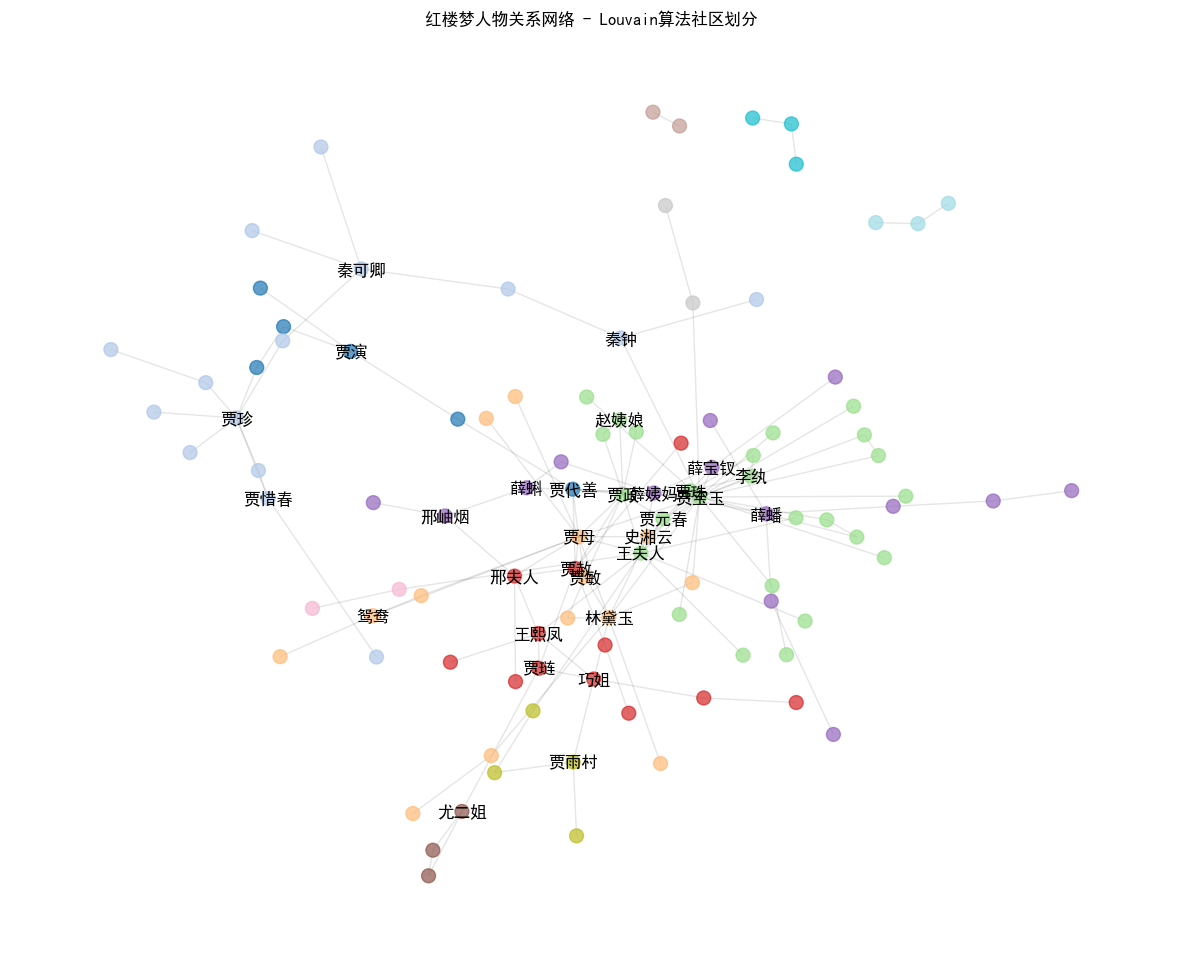

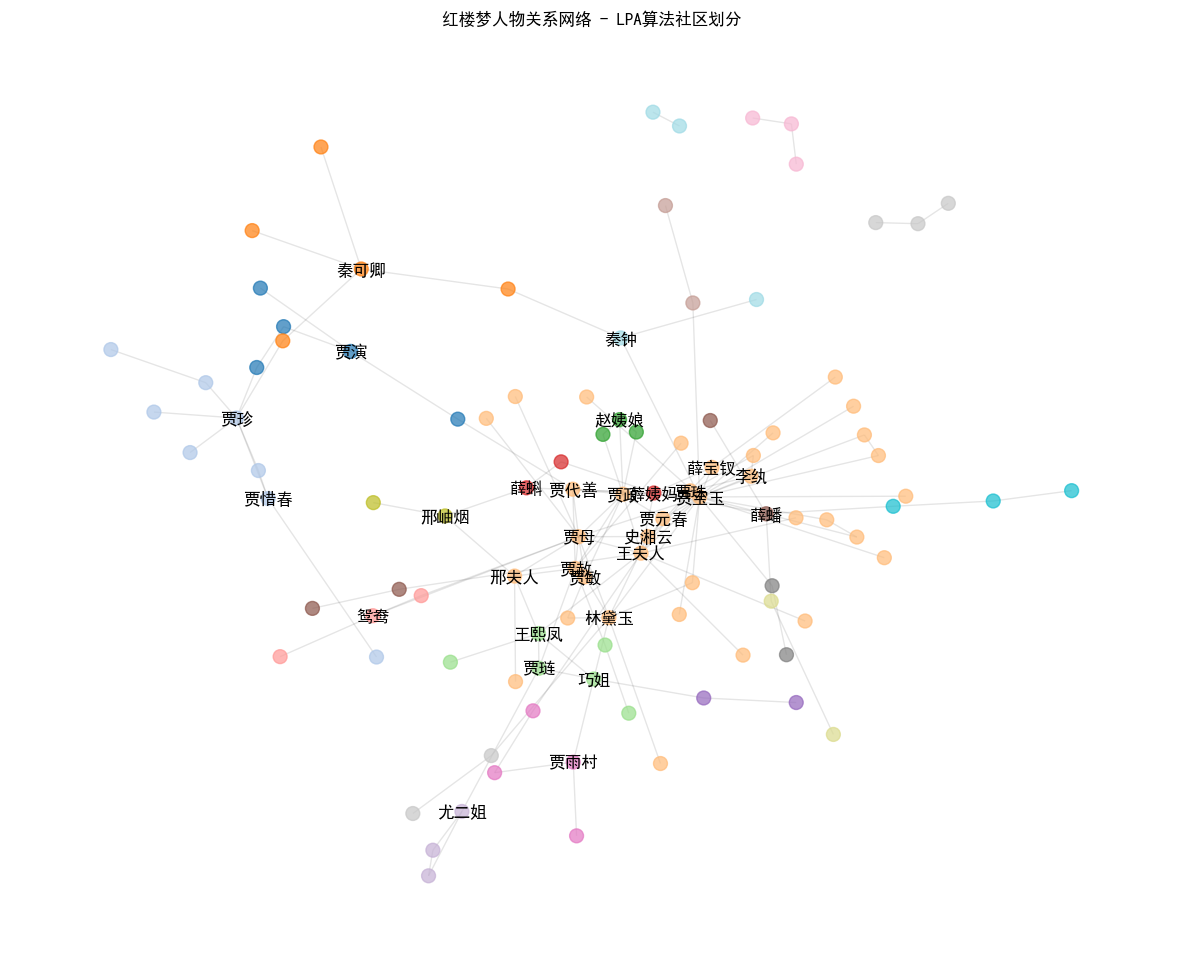

In [15]:
#######################
# TODO
# 可视化两个算法的社区划分
def plot_communities(G, partition, title):
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, seed=42, k=0.3)  # 增大k值使节点更分散
    
    # 为每个社区使用不同的颜色
    cmap = plt.get_cmap('tab20')
    node_colors = [partition[node] for node in G.nodes()]
    # 首先绘制所有边
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    # 按社区绘制节点
    nx.draw_networkx_nodes(G, pos, node_size = 100, alpha = 0.7, cmap = cmap, node_color = node_colors)
    # 找出度中心性最高的前N个节点来标注 # 即度数最高的前N个节点
    degree_centrality = nx.degree_centrality(G)
    top_n = 30
    top_nodes = sorted(degree_centrality.items(), key = lambda x: x[1], reverse = True)[:top_n] # x[1]是节点的度数，即x[1]=G.degree(x[0]) !!!!!!
    
    # 只为重要节点添加标签
    labels = {node: node for node, _ in top_nodes} # 这个没有惰性求值效应
    nx.draw_networkx_labels(G, pos, labels, font_size=12)
    plt.title(title)
    plt.axis('off')
    plt.show()
#####################

# 显示Louvain算法的社区划分
plot_communities(G_undir, partition_louvain, "红楼梦人物关系网络 - Louvain算法社区划分")

# 为了比较，也可以可视化LPA的结果
# 先将LPA结果转换为与Louvain结果相同的格式
partition_lpa = {}
for i, community in enumerate(communities_lpa):
    for node in community:
        partition_lpa[node] = i

plot_communities(G_undir, partition_lpa, "红楼梦人物关系网络 - LPA算法社区划分")

## 4. 阶层划分

参考引言部分，阶层划分可以基于不同的方案实现，下文提供的是方案A实现的样例
   - 方案A：基于度中心性, 介数中心性, 特征向量中心性等作为特征，使用聚类算法进行阶层划分
   - 方案B：指定少量阶层代表人物（如：高、中、低分别不超过5个），可以选取度数较高的代表，然后采用合理的算法（聚类-分类=社区划分等）实现人物的阶层自动标注。人工标注测试集（每个阶层不少于10个），评测算法的结果并进行分析。算法合理且分析报告内容比较深入的可获得+1分。
   - 方案C：指定少量阶层代表人物（如：高、中、低分别不超过5个），可以选取代表性高的人物。例如地位最高的，地位中间的，地位最低的，也可以选取度数比较高的，利用父子-姐妹-主仆等已知信息，采用合理算法实现更好的人物阶层标注，并对算法结果进行对比评测。算法合理且分析报告内容比较深入的可获得+1到2分。
   - 方案D：参考红楼梦文本，在方案C的基础上给出进一步的优化。算法合理且分析报告内容比较深入的可获得+1到3分。
   
   阶层划分不一定局限于3层，也可以多层。

样例方案A实现：

阶层划分实现基于网络中心性指标的人物社会阶层分析，首先计算人物节点的度中心性、介数中心性、特征向量中心性和接近中心性四种指标，然后使用层次聚类算法将人物划分为上中下三个阶层，最后分析各阶层的核心成员和家族分布情况，并通过三维散点图和网络图两种方式可视化阶层划分结果。

### 实现原理
1. 中心性指标计算：中心性指标是衡量节点在网络中重要性的关键指标，代码计算了四种常用的中心性指标
2. 特征矩阵构建与标准化：将四种中心性指标组合成特征矩阵，并进行标准化处理以消除量纲差异
3. 层次聚类实现阶层划分：使用层次聚类算法(Agglomerative Clustering)将人物划分为三个阶层
4. 层标签映射与排序：代码通过计算每个聚类的平均中心性，将聚类标签映射为有意义的阶层名称
5. 结果分析与可视化：代码分析了各阶层的核心成员和家族分布情况

这种基于中心性指标的多维聚类分析，能够客观地根据人物在关系网络中的位置和影响力进行阶层划分，揭示了《红楼梦》中人物社会地位的分层结构。

In [ ]:
# ================== 阶层划分 ==================
# 计算各种中心性指标
centrality_metrics = {}

# 仅使用人物节点(过滤掉家族节点)
character_nodes = [node for node in G_undir.nodes() if node in df['人物A'].values or node in df['人物B'].values]
character_subgraph = G_undir.subgraph(character_nodes)

print(f"计算中心性指标中，共 {len(character_nodes)} 个人物节点...")
#######################
# TODO：计算各种中心性指标
# 计算度中心性
centrality_metrics['degree'] = nx.degree_centrality(character_subgraph) 

# 计算介数中心性 (可能计算较慢)
centrality_metrics['betweenness'] = nx.closeness_centrality(character_subgraph)

# 计算特征向量中心性
centrality_metrics['eigenvector'] = nx.eigenvector_centrality(character_subgraph)

# 计算接近中心性
centrality_metrics['closeness'] = nx.betweenness_centrality(character_subgraph)
#######################

# 创建特征矩阵用于聚类
features = []
character_names = []

for node in character_nodes:
    # 收集节点的所有中心性指标作为特征
    node_features = [
        centrality_metrics['degree'].get(node, 0),
        centrality_metrics['betweenness'].get(node, 0),
        centrality_metrics['eigenvector'].get(node, 0),
        centrality_metrics['closeness'].get(node, 0)
    ]
    features.append(node_features)
    character_names.append(node)

# 特征标准化(使各特征量纲一致)
features_array = np.array(features)
features_mean = np.mean(features_array, axis=0)
features_std = np.std(features_array, axis=0)
features_scaled = (features_array - features_mean) / features_std

#######################
# TODO：使用层次聚类算法进行阶层划分
# 使用层次聚类算法，分为3个阶层: 上层/中上层/中下层
n_clusters = 3  
clustering = AgglomerativeClustering(n_clusters = n_clusters) # 层次聚类
"""没有affinity 和 linkage参数，默认使用欧氏距离和单链接"""
"""
Agglomerative Clustering（凝聚层次聚类）是一种自底向上的层次聚类方法。它从每个数据点作为单独的一个簇开始，然
后在每一步中合并两个最相似的簇，直到所有的数据点都属于一个簇或者达到某个停止条件为止。适合用来构建层次结构的数据视图，
并且不需要预先指定簇的数量（虽然可以设置期望的簇数量来截断树状图）。
"""
# 获取聚类结果
labels = clustering.fit_predict(features_scaled)
#########################

# 创建包含聚类结果的DataFrame
hierarchy_df = pd.DataFrame({
    '人物': character_names,
    '阶层': labels,
    '度中心性': [centrality_metrics['degree'].get(node, 0) for node in character_names],
    '介数中心性': [centrality_metrics['betweenness'].get(node, 0) for node in character_names],
    '特征向量中心性': [centrality_metrics['eigenvector'].get(node, 0) for node in character_names],
    '接近中心性': [centrality_metrics['closeness'].get(node, 0) for node in character_names]
})

# 添加家族信息
hierarchy_df['家族'] = hierarchy_df['人物'].map(
    lambda x: G.nodes[x].get('family', '未知') if x in G.nodes else '未知'
)

# 将阶层标签映射为更有意义的名称
hierarchy_map = {}
avg_centrality_by_class = {}

# 计算每个阶层的平均中心性指标
for i in range(n_clusters):
    class_data = hierarchy_df[hierarchy_df['阶层'] == i]
    avg_centrality = class_data['度中心性'].mean() + class_data['特征向量中心性'].mean()
    avg_centrality_by_class[i] = avg_centrality

# 根据平均中心性由高到低排序阶层
sorted_classes = sorted(avg_centrality_by_class.items(), key=lambda x: x[1], reverse=True)
hierarchy_names = ['上层', '中层', '下层']

# 映射聚类标签到阶层名称
for i, (class_id, _) in enumerate(sorted_classes):
    hierarchy_map[class_id] = hierarchy_names[i]

# 更新DataFrame中的阶层标签
hierarchy_df['阶层名称'] = hierarchy_df['阶层'].map(hierarchy_map)

# 排序并显示结果
print("\n==== 人物阶层划分结果 ====")
sorted_hierarchy = hierarchy_df.sort_values(by=['阶层', '度中心性'], ascending=[True, False])
print(sorted_hierarchy[['人物', '阶层名称', '家族', '度中心性']].head(15))

# 分析每个阶层的主要人物
print("\n==== 各阶层核心人物 ====")
for hierarchy_name in hierarchy_names:
    top_chars = hierarchy_df[hierarchy_df['阶层名称'] == hierarchy_name].nlargest(3, '度中心性')
    print(f"{hierarchy_name}:", ", ".join(top_chars['人物'].values))

# 统计不同阶层在不同家族中的分布
family_hierarchy_counts = pd.crosstab(
    hierarchy_df['家族'], 
    hierarchy_df['阶层名称'],
    normalize='index'  # 按行标准化，显示每个家族中不同阶层的比例
)

# 显示结果
print("\n==== 家族内阶层分布 ====")
print(family_hierarchy_counts)

# 将结果存储为变量供后续可视化使用
cross_tab = family_hierarchy_counts

计算中心性指标中，共 105 个人物节点...

==== 人物阶层划分结果 ====
     人物 阶层名称     家族      度中心性
8   贾惜春   下层  贾家宁国府  0.028846
31   鸳鸯   下层  贾家荣国府  0.028846
36   巧姐   下层  贾家荣国府  0.028846
41  尤二姐   下层  贾家宁国府  0.028846
43  赵姨娘   下层  贾家荣国府  0.028846
51   李纨   下层  贾家荣国府  0.028846
81   薛蝌   下层     薛家  0.028846
82  邢岫烟   下层     其他  0.028846
89  贾雨村   下层     其他  0.028846
1   贾代化   下层  贾家宁国府  0.019231
4    贾敬   下层  贾家宁国府  0.019231
6    尤氏   下层  贾家宁国府  0.019231
25   贾环   下层  贾家荣国府  0.019231
26  贾探春   下层  贾家荣国府  0.019231
28  贾迎春   下层  贾家荣国府  0.019231

==== 各阶层核心人物 ====
上层: 贾宝玉, 贾母, 王夫人
中层: 林黛玉, 贾赦, 贾珍
下层: 贾惜春, 鸳鸯, 巧姐

==== 家族内阶层分布 ====
阶层名称         上层        下层        中层
家族                                 
其他     0.000000  0.947368  0.052632
史家     0.500000  0.000000  0.500000
林家     0.000000  0.500000  0.500000
王家     0.250000  0.250000  0.500000
薛家     0.000000  0.600000  0.400000
贾家宁国府  0.000000  0.789474  0.210526
贾家荣国府  0.057143  0.714286  0.228571


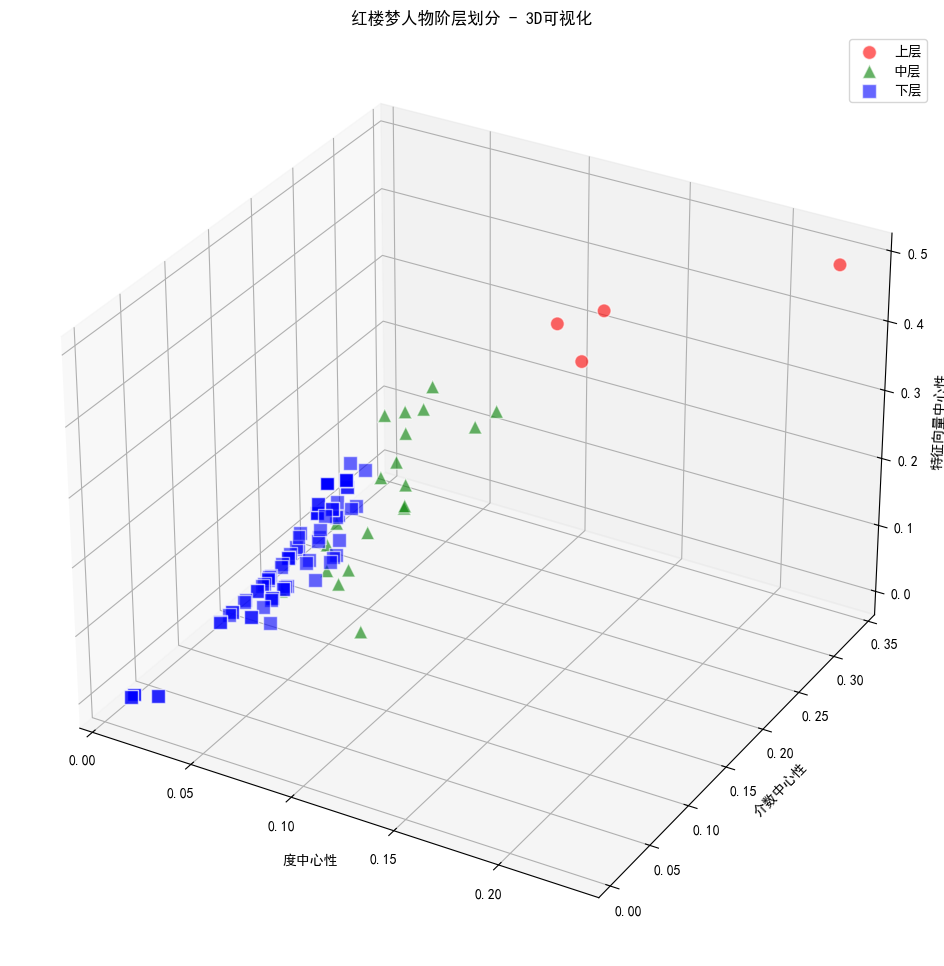

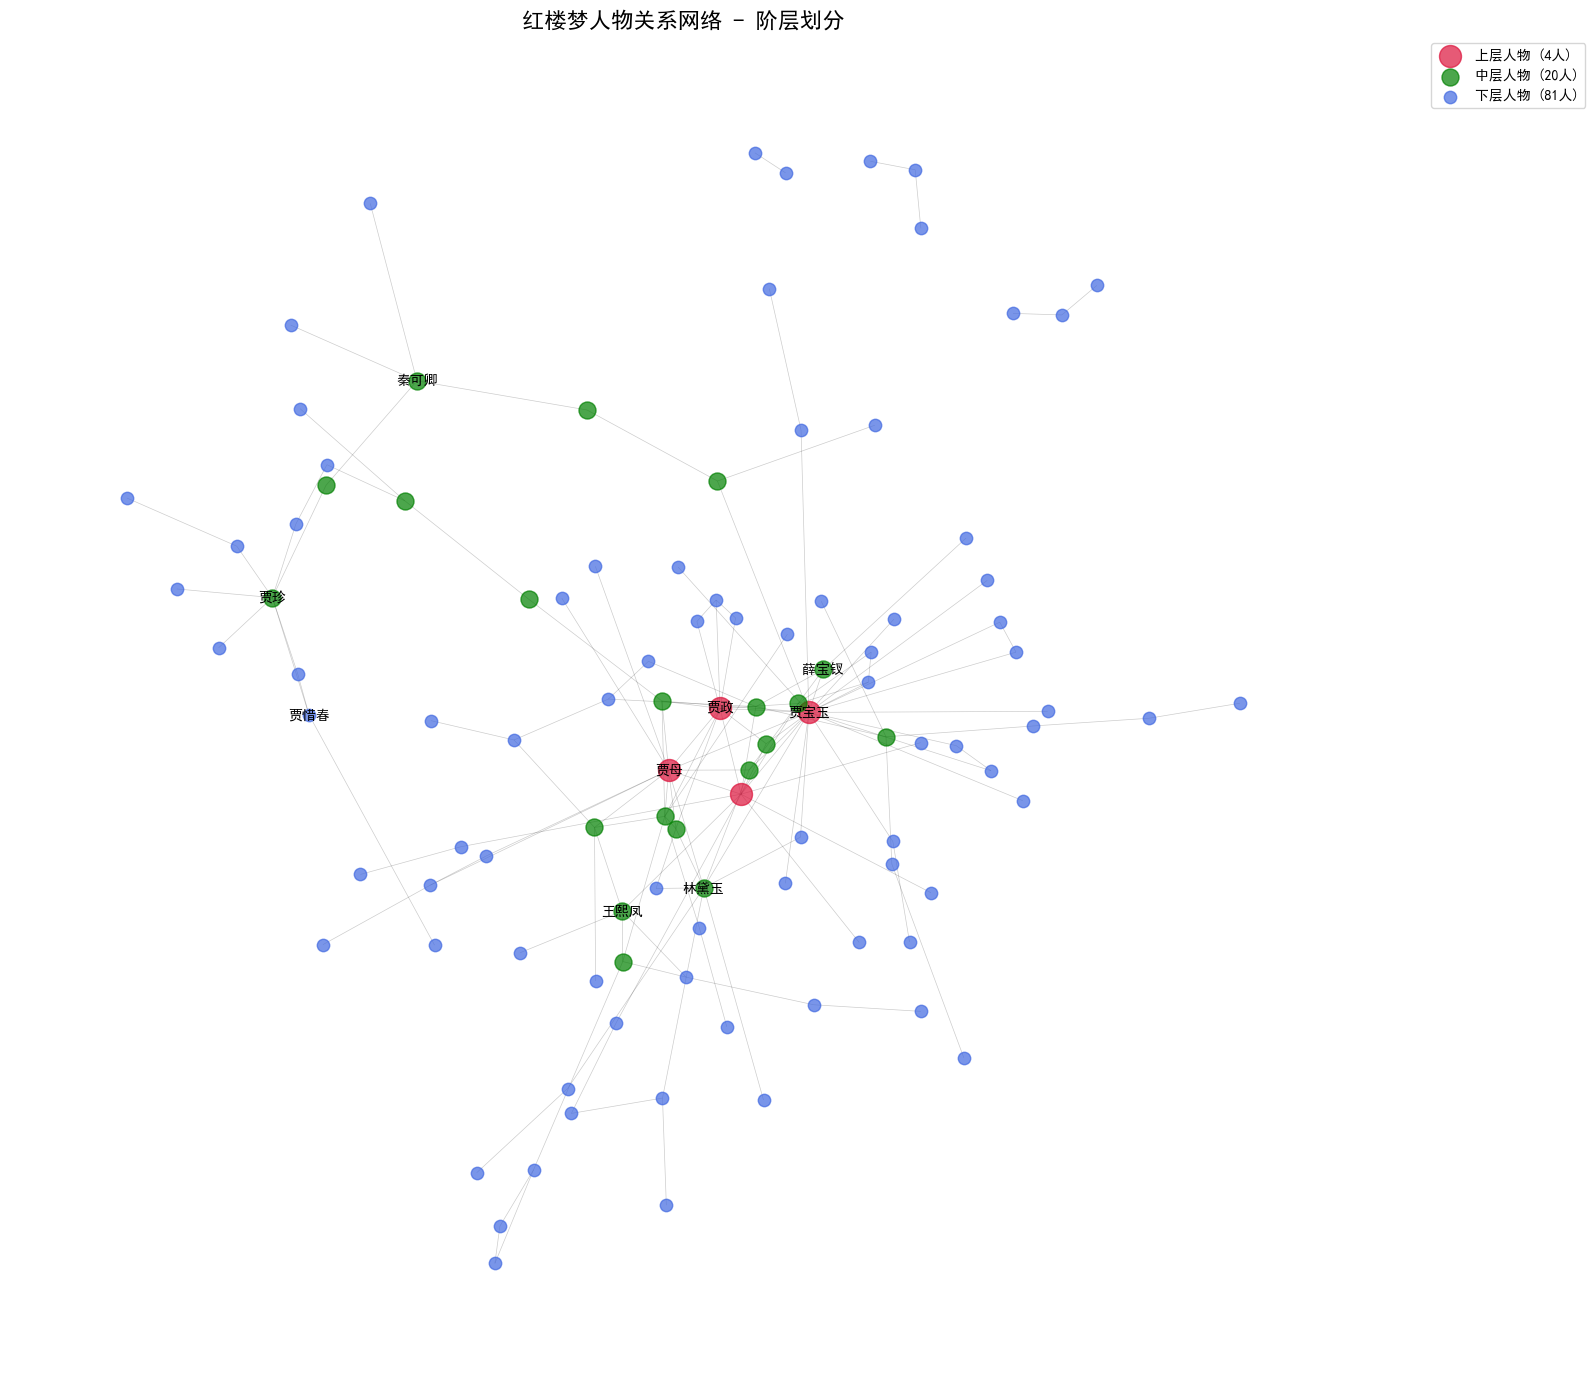

In [20]:
# 图节点可视化不同阶层
def plot_hierarchy_3d(hierarchy_df, title):
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')

    # 使用不同的颜色和形状表示不同的阶层
    colors = ['r', 'g', 'b']
    markers = ['o', '^', 's']

    for i, hierarchy_name in enumerate(hierarchy_names):
        class_data = hierarchy_df[hierarchy_df['阶层名称'] == hierarchy_name]
        x = class_data['度中心性']
        y = class_data['介数中心性']
        z = class_data['特征向量中心性']
        
        ax.scatter(x, y, z, 
                   c=colors[i], 
                   marker=markers[i], 
                   label=hierarchy_name, 
                   alpha=0.6, 
                   edgecolors='w', 
                   s=100)  # 调整点的大小

    ax.set_xlabel('度中心性')
    ax.set_ylabel('介数中心性')
    ax.set_zlabel('特征向量中心性')
    ax.set_title(title)
    ax.legend()
    plt.show()

# 创建一个更直观的可视化，同时突出关键人物
def plot_network_hierarchy(G_undir, hierarchy_df, important_people):
    plt.figure(figsize=(16, 14))
    
    # 使用Fruchterman-Reingold布局算法
    pos = nx.spring_layout(G_undir, seed=42, k=0.3)
    
    # 定义每个阶层节点的大小
    node_sizes = {'上层': 250, '中层': 150, '下层': 80}
    
    # 绘制所有边
    nx.draw_networkx_edges(G_undir, pos, alpha=0.2, width=0.5)
    
    # 绘制家族节点
    family_nodes = [node for node, attr in G.nodes(data=True) 
                    if attr.get('type') == 'family' and node in G_undir.nodes()]
    if family_nodes:
        nx.draw_networkx_nodes(G_undir, pos, 
                              nodelist=family_nodes,
                              node_color='gray',
                              alpha=0.8,
                              node_size=200,
                              label='家族')
    
    # 绘制各阶层人物节点
    for i, level in enumerate(['上层', '中层', '下层']):
        level_data = hierarchy_df[hierarchy_df['阶层名称'] == level]
        nodes = level_data['人物'].tolist()
        valid_nodes = [n for n in nodes if n in G_undir.nodes()]
        
        if valid_nodes:
            nx.draw_networkx_nodes(G_undir, pos,
                                  nodelist=valid_nodes,
                                  node_color=['crimson', 'green', 'royalblue'][i],
                                  node_size=node_sizes[level],
                                  alpha=0.7,
                                  label=f'{level}人物 ({len(valid_nodes)}人)')
    
    # 标注重要人物
    important_labels = {node: node for node in important_people if node in G_undir.nodes()}
    nx.draw_networkx_labels(G_undir, pos, 
                           labels=important_labels,
                           font_size=10,
                           font_weight='bold',
                           font_color='black')
    
    plt.title('红楼梦人物关系网络 - 阶层划分', fontsize=16)
    plt.legend(scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 核心人物
important_people = ['贾母', '王熙凤', '贾宝玉', '林黛玉', '薛宝钗', 
                   '贾政', '贾珍', '秦可卿', '贾惜春']

# 可视化三维特征空间中的阶层划分
plot_hierarchy_3d(hierarchy_df, "红楼梦人物阶层划分 - 3D可视化")

# 可视化网络中的阶层分布
plot_network_hierarchy(G_undir, hierarchy_df, important_people)
